#### 개와 고양이를 활용한 이진 분류

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader

**GPU 활성화**

In [7]:
device = torch.device("mps" if torch.backends.mps.is_available() else 'cpu')
print(f'Using device {device}')

Using device mps


**이미지 가져오기**

In [24]:
import os

train_path = '../data/dogsvscats/train'
test_path = '../data/dogsvscats/train'
print(os.getcwd()) # 현재 경로 반환

if os.path.exists(train_path):
    print('✅ train 이미지 폴더 존재')
else:
    print('❌ train 이미지 폴더 미존재')

if os.path.exists(test_path):
    print('✅ test 이미지 폴더 존재')
else:
    print('❌ test 이미지 폴더 미존재')


/Users/songbeom/PythonWorkSpace/CNN_project/notebooks
✅ train 이미지 폴더 존재
✅ test 이미지 폴더 존재


In [54]:
import glob
import os

train_dir = '../data/dogsvscats/train'
test_dir = '../data/dogsvscats/test'

test_list = glob.glob(os.path.join(test_dir, '*.jpg'))
all_train_files = glob.glob(os.path.join(train_dir, '*.jpg'))
all_train_files

['../data/dogsvscats/train/dog.8011.jpg',
 '../data/dogsvscats/train/cat.5077.jpg',
 '../data/dogsvscats/train/dog.7322.jpg',
 '../data/dogsvscats/train/cat.2718.jpg',
 '../data/dogsvscats/train/cat.10151.jpg',
 '../data/dogsvscats/train/cat.3406.jpg',
 '../data/dogsvscats/train/dog.1753.jpg',
 '../data/dogsvscats/train/cat.4369.jpg',
 '../data/dogsvscats/train/cat.7660.jpg',
 '../data/dogsvscats/train/dog.5535.jpg',
 '../data/dogsvscats/train/cat.8553.jpg',
 '../data/dogsvscats/train/cat.9895.jpg',
 '../data/dogsvscats/train/cat.1211.jpg',
 '../data/dogsvscats/train/dog.3144.jpg',
 '../data/dogsvscats/train/dog.775.jpg',
 '../data/dogsvscats/train/dog.11102.jpg',
 '../data/dogsvscats/train/cat.6218.jpg',
 '../data/dogsvscats/train/dog.11664.jpg',
 '../data/dogsvscats/train/dog.3622.jpg',
 '../data/dogsvscats/train/cat.1577.jpg',
 '../data/dogsvscats/train/cat.12020.jpg',
 '../data/dogsvscats/train/dog.5253.jpg',
 '../data/dogsvscats/train/cat.7106.jpg',
 '../data/dogsvscats/train/cat.

In [ ]:
# 지도 학습을 위해 target 목표 변수 값 뽑아오기
train_labels = [ train_label.split('/')[-1].split('.')[0] for train_label in all_train_files ]
train_labels[:10]

['dog', 'cat', 'dog', 'cat', 'cat', 'cat', 'dog', 'cat', 'cat', 'dog']

In [48]:
from torchvision.io import read_image
img = read_image(all_train_files[0])
print(img.size())

from PIL import Image
img = Image.open(all_train_files[0])
img.size

torch.Size([3, 500, 380])


(380, 500)

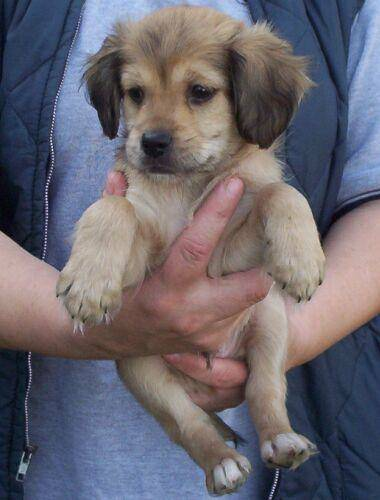

In [49]:
import IPython

image1 = IPython.display.Image(filename=all_train_files[0])
display(image1)

In [53]:
from sklearn.model_selection import train_test_split

train_list , val_list = train_test_split(all_train_files, test_size=0.1, stratify=train_labels, random_state=0)
print(len(train_list), len(val_list))

22500 2500


In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.io import read_image

# 1. 학습 데이터 전처리 (Augmentation 포함)
# transforms.Compose 를 사용해서 여러 개의 이미지 전처리 작업을 순서대로 연결 해줍니다.
train_transform = transforms.Compose([
    transforms.Resize([224, 224]), # 크기 (224, 224) 통일
    transforms.RandomHorizontalFlip(), # 좌우 반전
    transforms.RandomRotation(10), # ±10도 회전
    transforms.ColorJitter(brightness=0.2, contrast=0.2), # 밝기/대비 변화
    transforms.ToTensor(), # Tensor로 변환 (0 ~ 1)
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

# 2. 검증/테스트 데이터 전처리 (Augmentation 미포함)
val_transform = transforms.Compose([
    transforms.Resize([224, 224]), # 크기 (128, 128) 통일
    transforms.ToTensor(), # Tensor로 변환 (0 ~ 1)
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

# class Dataset
class CustomImageDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        if img_path.split('/')[-1][-3:] == 'jpg':
            img = Image.open(img_path)
            if self.transform is not None:
                img_transform = self.transform(img)
                label = img_path.split("/")[-1].split('.')[0]
                if label == 'dog':
                    label = 1
                elif label == 'cat':
                    label = 0
        return img_transform, label
    
dataset_train = CustomImageDataset(train_list, transform=train_transform)
dataset_valid = CustomImageDataset(val_list, transform=val_transform)
dataset_test = CustomImageDataset(test_list, transform=val_transform)

train_batches = DataLoader(dataset=dataset_train, batch_size=8, shuffle=True)
valid_batches = DataLoader(dataset=dataset_valid, batch_size=8, shuffle=False)
test_batches = DataLoader(dataset=dataset_test, batch_size=8, shuffle=False)